In [101]:
import pandas as pd
import selfies as sf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem
from collections import Counter
import seaborn as sns
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import csv
import selfies as sf
from collections import Counter
import torch.nn as nn
import csv
import os

# Create Embedding for SMILES

In [102]:
token_counter = Counter()
num_processed = 0
first_10_encodings = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        smiles = row[0].strip()
        try:
            selfies_str = sf.encoder(smiles)
            tokens = list(sf.split_selfies(selfies_str))
            token_counter.update(tokens)

            # put encodings in a list to print
            if len(first_10_encodings) < 10:
                first_10_encodings.append((smiles, selfies_str, tokens))

        except Exception as e:
            continue

        num_processed += 1
        if num_processed % 10000 == 0:
            print(f"Processed {num_processed} molecules")

# test to see if this actually works
#print("\n encodings:")
#for i, (smiles, selfies_str, tokens) in enumerate(first_10_encodings, 1):
#    print(f"{i}. SMILES: {smiles}")
#    print(f"   SELFIES: {selfies_str}")
#    print(f"   Tokens: {tokens}")

# create the vocab
special_tokens = ['[PAD]', '[SOS]', '[EOS]', '[UNK]']
unique_tokens = list(token_counter.keys())
vocab = special_tokens + sorted(unique_tokens)

token2idx = {token: idx for idx, token in enumerate(vocab)}
idx2token = {idx: token for token, idx in token2idx.items()}

# create tokenized encoding:
def encode_tokens(tokens, token2idx):
    return [token2idx.get(token, token2idx['[UNK]']) for token in tokens]

max_len = 1801  # should be the same size as the spectra
encoded_sequences = []  # input data

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        smiles = row[0].strip()
        try:
            selfies_str = sf.encoder(smiles)
            tokens = list(sf.split_selfies(selfies_str))
            token_ids = encode_tokens(tokens, token2idx)
            encoded_sequences.append(token_ids)
        except:
            continue

# pad to fixed length
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_len, padding='post', value=token2idx['[PAD]'])

print(f"\n checklength: {padded_sequences.shape[1]}")  # should be 1801

# lets see if it works
print("sirst encoding as token indices:")
print(padded_sequences[0])

def decode_vector_to_smiles(vector, idx2token):
    # convert indices to tokens
    tokens = [idx2token[idx] for idx in vector if idx2token[idx] != '[PAD]']

    # joins tokens into a SELFIES string
    selfies_str = ''.join(tokens)

    # decode SELFIES → SMILES
    try:
        smiles = sf.decoder(selfies_str)
        return smiles
    except:
        return None


#first 5 tokenized & padded sequences
#print("\nTokenized and padded sequences (first 5):")
#for i in range(5):
#    print(f"{i+1}: {padded_sequences[i]}")

# make sure we actually got valid encodings (slay)
if len(first_10_encodings) > 0:
    # OG data
    original_smiles = first_10_encodings[0][0]
    original_tokens = first_10_encodings[0][2]
    encoded_vector = padded_sequences[0]

    # decode back to SMILES
    reconstructed_smiles = decode_vector_to_smiles(encoded_vector, idx2token)

    # test results
    print("\nEncoding Test")
    print("OG SMILES:     ", original_smiles)
    print("OG Tokens:     ", original_tokens)
    print("Token Indices:       ", encoded_vector[:len(original_tokens)])  # this unpads it
    print("Reconstructed SMILES:", reconstructed_smiles)
else:
    print("No valid SMILES womp womp...")




 checklength: 1801
sirst encoding as token indices:
[34 43 28 ...  0  0  0]

Encoding Test
OG SMILES:      CN(c1ccc(NC(=O)Nc2ccccc2)cc1)S(=O)(=O)c1ccc(-c2ccn(CCO)n2)s1
OG Tokens:      ['[C]', '[N]', '[Branch2]', '[Ring1]', '[=Branch2]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[#C]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[C]', '[=C]', '[Ring1]', '[S]', '[S]', '[=Branch1]', '[C]', '[=O]', '[=Branch1]', '[C]', '[=O]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[=N]', '[C]', '[C]', '[=C]', '[N]', '[Branch1]', '[Ring2]', '[C]', '[C]', '[O]', '[N]', '[=Ring1]', '[Branch2]', '[S]', '[Ring1]', '[=N]']
Token Indices:        [34 43 28 50 14 34 15 34 15 27  6 43 34 13 34 21 43 34 15 34 15 34 15 50
 13 34 15 50 52 52 13 34 21 13 34 21 34 15 34 15 27 20 34 34 15 43 27 51
 34 34 46 43 23 28 52 50 20]
Reconstructed SMILES: CN(C1=CC=C(NC(=O)NC2=CC=CC=C2)C=C1)S(=O)(=O)C3=CC=C(C=4C=CN(CCO)N=4)S3


# Create Dataframe

In [103]:
X = padded_sequences 
spectra = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader) 
    for row in reader:
        try:
            spec = [float(v) for v in row[1:1802]] 
            if len(spec) == 1801:
                spectra.append(spec)
        except:
            continue

X = X[:len(spectra)]

# create df
df = pd.DataFrame({
    "encoded_smiles": list(X),
    "spectra": spectra
})

# testinggg
print("First 10 encoded tokens:", df.iloc[0]['encoded_smiles'][:10])
print("First 10 spectra values:", df.iloc[0]['spectra'][:10])

print("Length of encoded_smiles vector:", len(df.iloc[0]['encoded_smiles']))
print("Length of spectra vector:", len(df.iloc[0]['spectra']))

print("Full encoded_smiles vector:", df.iloc[0]['encoded_smiles'])
print("Full spectra vector:", df.iloc[0]['spectra'])


First 10 encoded tokens: [34 43 28 50 14 34 15 34 15 27]
First 10 spectra values: [0.0007712866294600632, 0.0007723908046661789, 0.000774465837466059, 0.0007847973157695205, 0.0007924847952294243, 0.0007974891704944533, 0.0007999480379269527, 0.0008086159723132459, 0.0008120453741895288, 0.0008153232389547017]
Length of encoded_smiles vector: 1801
Length of spectra vector: 1801
Full encoded_smiles vector: [34 43 28 ...  0  0  0]
Full spectra vector: [0.0007712866294600632, 0.0007723908046661789, 0.000774465837466059, 0.0007847973157695205, 0.0007924847952294243, 0.0007974891704944533, 0.0007999480379269527, 0.0008086159723132459, 0.0008120453741895288, 0.0008153232389547017, 0.0008237638508585554, 0.0008345718056421103, 0.0008496019539248808, 0.0008605721963095523, 0.0008729362666560199, 0.0008860055004255269, 0.0008934067042321944, 0.0009166259796892721, 0.0009311179264626959, 0.0009422418349666756, 0.0009607422498414929, 0.000969887143792212, 0.000979747922820859, 0.00099596110856551

# INN Model:
## Goal: SMILES embedding (X)  ⟷  Spectra (Y)

### Coupling Layer:


In [104]:
class CouplingLayer(nn.Module):
    def __init__(self, dim, hidden_dim, mask):
        super().__init__()
        self.mask = mask # binary mask, (0/1) tensor of shape dim

        # scale and translate are subnetworks used in RealNVP (are only applied to unmasked part of the input)
        self.scale_net = nn.Sequential(nn.Linear(dim, hidden_dim),nn.ReLU(), nn.Linear(hidden_dim, dim),nn.Tanh())  
        self.translate_net = nn.Sequential(nn.Linear(dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, dim))  

    def forward(self, x): # Smiles -> Spectra
        x_masked = x * self.mask # mask part of the input (x1)
        s = self.scale_net(x_masked) * (1 - self.mask) # first part of the transformation (x2)
        t = self.translate_net(x_masked) * (1 - self.mask) # second part of the transformation
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t) # combines to create y (go to spectra)
        return y

    def inverse(self, y): # computes the inverse (Spectra -> Smiles)
        y_masked = y * self.mask # mask part of the input (x1)
        s = self.scale_net(y_masked) * (1 - self.mask) # transformation 1
        t = self.translate_net(y_masked) * (1 - self.mask) # transformation 2 
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s)) # combines to create x (go back to smiles)
        return x

### Build RealNVP Model:

In [105]:
class RealNVP(nn.Module):
    def __init__(self, dim, hidden_dim, num_blocks=6): # num_blocks = number of coupling layers stacked
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_blocks):
            mask = self.get_mask(i, dim)
            self.layers.append(CouplingLayer(dim, hidden_dim, mask))

    def get_mask(self, i, dim):
        mask = torch.zeros(dim)
        mask[i % 2::2] = 1
        return mask
    
    def forward(self, x): # smile -> spectra
        for layer in self.layers:
            x = layer(x)
        return x
    
    def inverse(self, y): # spectra -> smile
        for layer in reversed(self.layers):
            y = layer.inverse(y)
        return y

## Train and Try :)
### Create Pytorch Dataset

Train size: 2854, Test size: 714
Epoch 1, Training Loss: 810.1117
Epoch 2, Training Loss: 34.9280
Epoch 3, Training Loss: 12.6455
Epoch 4, Training Loss: 6.5597
Epoch 5, Training Loss: 4.3172
Epoch 6, Training Loss: 3.1637
Epoch 7, Training Loss: 2.5083
Epoch 8, Training Loss: 2.1144
Epoch 9, Training Loss: 1.8543
Epoch 10, Training Loss: 1.6694

Test MSE: 0.0354
Test R² Score: -1920485.5000


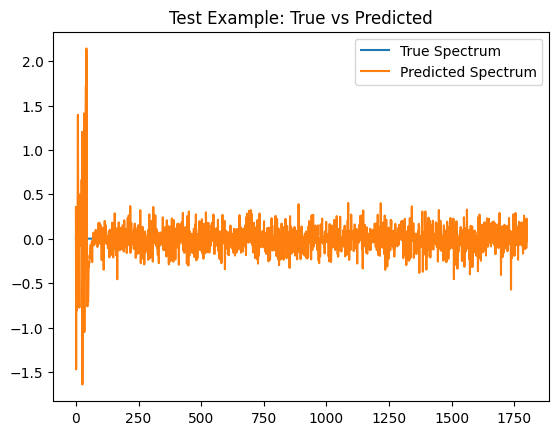

In [106]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#  train/test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# dataset class
class SmilesSpectraDS(Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df['encoded_smiles'].tolist(), dtype=torch.float32)
        self.Y = torch.tensor(df['spectra'].tolist(), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# datasets and dataloaders
train_dataset = SmilesSpectraDS(train_df)
test_dataset = SmilesSpectraDS(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# define model
model = RealNVP(dim=1801, hidden_dim=512, num_blocks=6)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# train model
for epoch in range(10):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}")

# evaluate on test set
model.eval()
test_loss = 0
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        test_loss += loss.item()
        y_true_all.append(y_batch)
        y_pred_all.append(y_pred)

y_true = torch.cat(y_true_all).numpy()
y_pred = torch.cat(y_pred_all).numpy()

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest MSE: {mse:.4f}")
print(f"Test R² Score: {r2:.4f}")

# plot an example
plt.figure(figsize=(12, 5))

# True spectrum
plt.subplot(1, 2, 1)
plt.plot(y_test[0].numpy(), label='True Spectrum', color='blue')
plt.title("True Spectrum")
plt.xlabel("Wavelength index")
plt.ylabel("Intensity")
plt.legend()

# Predicted spectrum
plt.subplot(1, 2, 2)
plt.plot(y_pred[0].detach().numpy(), label='Predicted Spectrum', color='orange')
plt.title("Predicted Spectrum")
plt.xlabel("Wavelength index")
plt.ylabel("Intensity")
plt.legend()

plt.tight_layout()
plt.show()





In [108]:
print("Values 600 to 620 of true spectra:\n", y_test[0].numpy()[600:621])
print("\nValues 600 to 620 of predicted spectra:\n", y_pred[0].detach().numpy()[600:621])

Values 600 to 620 of true spectra:
 [0.00397585 0.00400259 0.0040617  0.00407845 0.0040488  0.00398007
 0.00388468 0.00371987 0.00349467 0.00325838 0.00299059 0.00275474
 0.00251035 0.00227593 0.00203801 0.00185272 0.0016717  0.00149945
 0.00133905 0.00118203 0.00106313]

Values 600 to 620 of predicted spectra:
 [-0.08616679  0.07569882 -0.07207042  0.03708842  0.03981304 -0.11781627
  0.07242435 -0.1775232  -0.04147932 -0.13484105  0.03012627 -0.18491687
  0.01746273 -0.04636008  0.0791682  -0.08086455 -0.00316346  0.14905095
 -0.08838129 -0.05790412  0.03314793]
